## Assignment 3: Solving the wave equation using PINNs

In this assignment, you will be exploring Physics-Informed Neural Networks (PINNs) and building up to solving the 2d wave equation. The wave equation is a second-order partial differential equation that describes how waves propagate over time. It is used in many fields, including acoustics, optics, and seismology.

#### Objectives:
- Understand the wave equation and its applications.
- Develop a Physics-Informed Neural Network (PINN) to solve the wave equation.
- Explore the impact of different hyperparameters on the performance of the PINN.

## Task 1: investigate how well the PINN scales to higher frequency oscillations (20 marks)


The first task is to investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

Specifically, go back to simulating the solution to the harmonic oscillator and see what happens when you **increase** $\omega_0$ from 20 to 80.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
# Your code here


## Task 2: Implement the ansatz formulation (20 marks)

You should find that the PINN struggles to converge, even if the number of physics training points is increased.

This is a harder problem for the PINN to solve, in part because of the **spectral bias** of neural networks, as well as the fact more training points are required.

#### Approach: alternative "ansatz" formulation

To speed up convergence, one way is to **assume something** about the solution. 

For example, suppose we know from our physics intuition that the solution is in fact sinusodial.

Then, instead of having the PINN directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

We instead use the PINN as part of a mathematical ansatz of the solution, i.e.

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

where $\alpha, \beta$ are treated as additional learnable parameters.

Comparing this ansatz to the exact solution

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

We see that now the PINN only needs to learn the exponential function, which should be a much easier problem.

Again, autodifferentiation allows us to easily differentiate through this ansatz to train the PINN!

In [ ]:
# Your code here

## Task 3: Extend the inversion task (20 marks)

See how far you can push the inversion task: can you discover $m$, $\mu$ and $k$ simultaneously (and therefore, discover the entire underlying equation?)

In [ ]:
# Your code here

## Task 4: Solve the 1D wave equation (40 marks)

Finally, we will solve the 1D (one space dimension plus time) wave equation using PINNs. The 1D wave equation is given by:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

where $u(x, t)$ is the wave function, and $c$ is the wave speed.

You will need to modify the PINN to handle the 1D wave equation and experiment with different hyperparameters to improve the convergence of the model.

Explore the impact of different physics sampling points, neural network architectures, and optimization algorithms on the performance of the PINN for solving the 1D wave equation.

torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([1600, 2])
torch.Size([10000, 2])


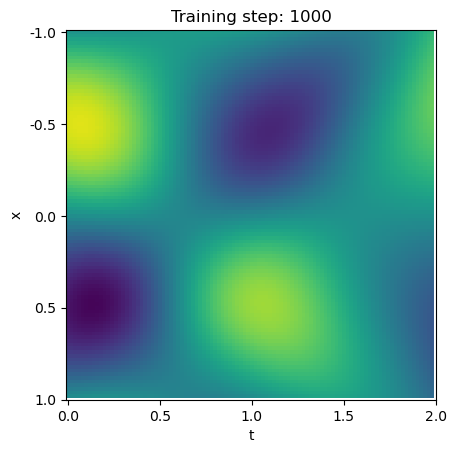

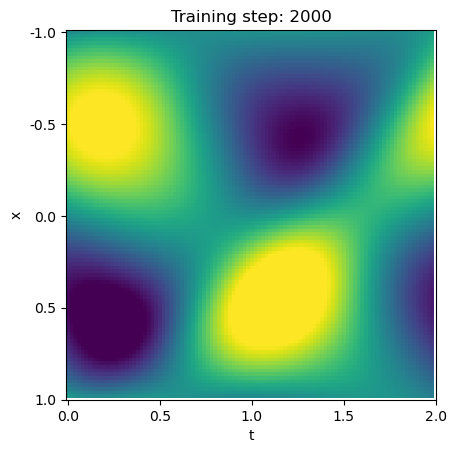

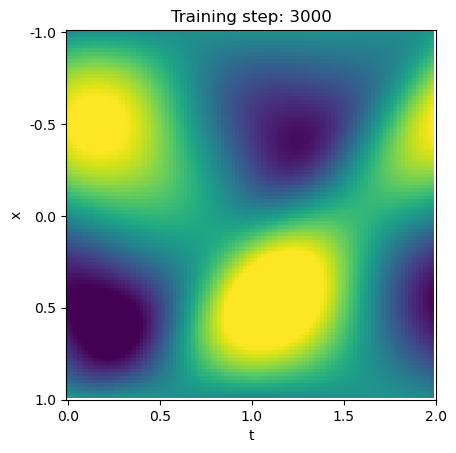

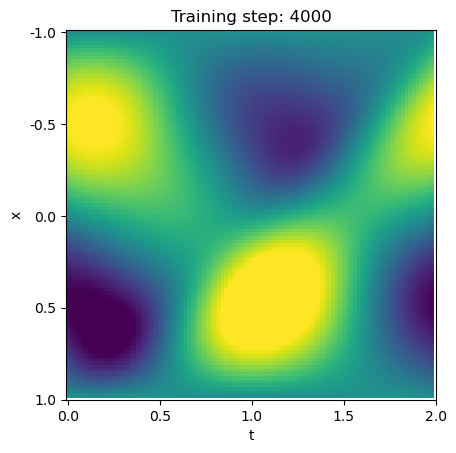

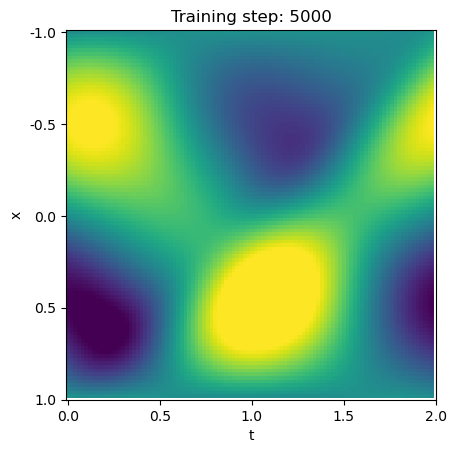

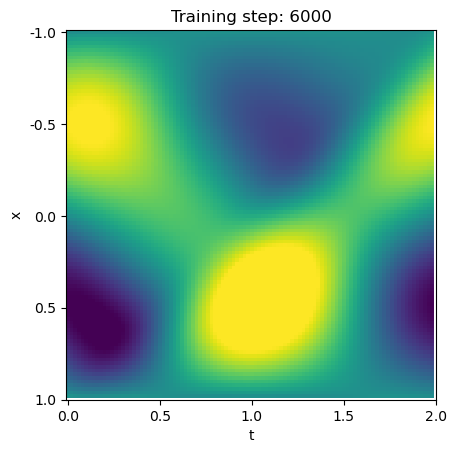

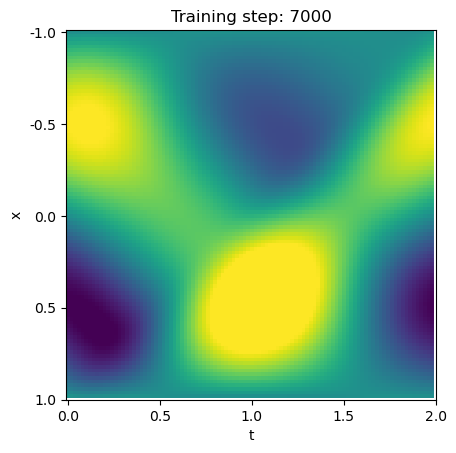

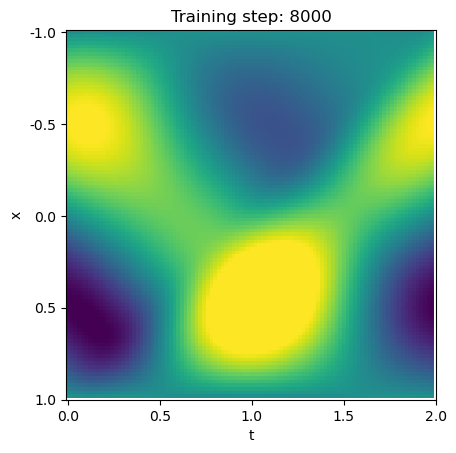

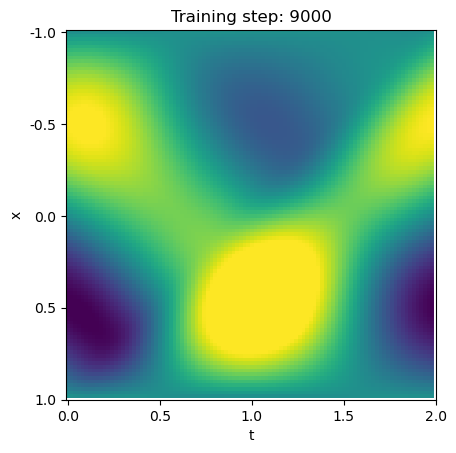

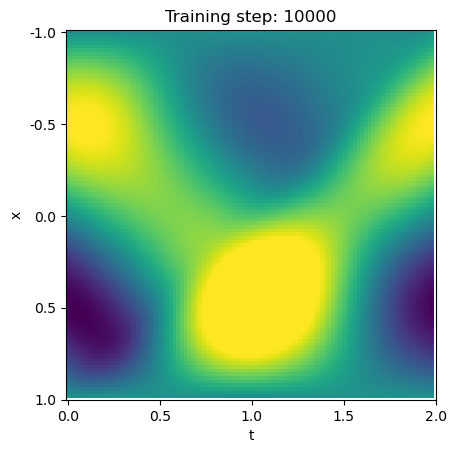

In [1]:
"""Solves the 1-D Wave equation
    d^2u          d^2 u
    ----  = c^2 * -----
    dt^2          dx^2   

    for -1.0 < x < +1.0, and 0 < t

    Boundary conditions:
    u(x,0) = - sin(pi*x)
    u(-1,t) = u(+1,t) = 0
"""

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

    
# get boundary training points
x1 = torch.stack([-torch.ones(40), torch.linspace(0,2,40)],-1)
u1 = torch.zeros_like(x1[:,0:1])
print(x1.shape, u1.shape)

x2 = torch.stack([torch.ones(40), torch.linspace(0,2,40)],-1)
u2 = torch.zeros_like(x2[:,0:1])
print(x2.shape, u2.shape)

x3 = torch.stack([torch.linspace(-1,1,40), torch.zeros(40)],-1)
u3 = -torch.sin(np.pi*x3[:,0:1])
print(x3.shape, u3.shape)

# get physics loss sample points over full domain
xs = [torch.linspace(-1,1,40), torch.linspace(0,2,40)]
x_physics = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2).requires_grad_(True)
print(x_physics.shape)

# get testing locations
xs = [torch.linspace(-1,1,100), torch.linspace(0,2,100)]
x_test = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2)
print(x_test.shape)
    

# define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

c=1.0
torch.manual_seed(123)
model = FCN(2,1,64,4)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
for i in range(10000):
    optimizer.zero_grad()
    
    # compute the "boundary loss"
    y1, y2, y3 = model(x1), model(x2), model(x3)
    loss1 = torch.mean((y1-u1)**2) + torch.mean((y2-u2)**2) + torch.mean((y3-u3)**2)
    
    # compute the "physics loss"
    u = model(x_physics)
    dx  = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]# computes du/dx and du/dt
    dx, dt = dx[:,0:1], dx[:,1:2]
    dx1dx = torch.autograd.grad(dx, x_physics, torch.ones_like(u), create_graph=True)[0]# computes d^2u/dx^2
    dx1dx1 = dx1dx[:,0:1]
    dt1dt = torch.autograd.grad(dt, x_physics, torch.ones_like(u), create_graph=True)[0]# computes d^2u/dt^2
    dt1dt1 = dt1dt[:,1:2]
    physics = (dt1dt1[:,0]) - (c * dx1dx1[:,0]) # computes the residual of the Wave eqn
    loss2 = (0.1)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        y = model(x_test)
        plt.figure()
        plt.imshow(y.reshape(100,100).detach(), vmin=-1, vmax=1)
        plt.xticks(np.linspace(0,100,5).astype(int), np.linspace(0,2,5))
        plt.yticks(np.linspace(0,100,5).astype(int), np.linspace(-1,1,5))
        plt.xlabel("t"); plt.ylabel("x")
        plt.title("Training step: %i"%(i+1))
        plt.show()

## Task 5: BONUS - Solve the 2D wave equation (25 extra marks)

See this paper for some hints: https://arxiv.org/pdf/2006.11894

In [ ]:
# Your code here

### Submission Guidelines:
- Format: Jupyter Notebook with annotations and text descriptions inline. Roughly 5-15 pages, including code and figures, if it were printed.
- Deadline: **1 week from the assignment date.**